# Implementation of a simple Auto Encoder

*Inspiration*: https://github.com/shaohua0116/VAE-Tensorflow/blob/master/demo.ipynb

## Introduction

Reconstruct images of numbers using a (Variational) Auto Encoder with 3 hidden layers and symmetric encoding and decoding.

## Improvement Ideas

- Implement more complex structures
- Improve the Tensorflow dashboard (not functional in this form)
- Use GAN strategies with a counterplayer.

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected as fc

### Prepare Images

In [12]:
# load images from keras
(train_images_inp, train_labels), (test_images_inp, test_labels) = tf.keras.datasets.mnist.load_data()

# reshape images to flat and one-hot encode
train_images = train_images_inp.reshape(train_images_inp.shape[0], 28*28)/255
with tf.Session() as sess:
    train_labels_one_hot = sess.run(tf.one_hot(train_labels, 10))
test_images = test_images_inp.reshape(test_images_inp.shape[0], 28*28)/255
dim = train_images.shape[1]
n = train_images.shape[0]

In [1]:
### Define the Encoder

In [25]:
class Encoder: 
    """
    Encode inputs to an embedding. Structure is fixed and must be modified in src. 
    :param zn: Size of embedding
    """
    def __init__(self, zn):
        self.zn = zn
        self.eps = 1e-4
        self.learn_rate = 1e-4
        self.trained_imgs = 0
        
        # build the model
        self.build()
        # start and store session
        self.sess = tf.Session()
        # initialised all variables
        self.sess.run(tf.global_variables_initializer())
        self.merge = tf.summary.merge_all()
        
        
    def build(self):
        with tf.name_scope("Encoder"):
            self.input = tf.placeholder(shape=[None, dim], dtype=tf.float32, name="Input_Picture")
            self.y = tf.placeholder(shape=[None, 10], dtype=tf.float32, name="Label")

            self.h1 = fc(self.input, 256, activation_fn=tf.nn.relu)
            self.h2 = fc(self.h1, 128, activation_fn=tf.nn.relu)
            self.h3 = fc(self.h2, 64, activation_fn=tf.nn.relu)

            self.y_hat = fc(self.h3, self.zn, activation_fn=tf.nn.softmax)

            self.loss = tf.reduce_mean(-tf.reduce_sum(self.y * tf.log(self.y_hat), axis=1))
            tf.summary.scalar("Encoder_Loss", self.loss)

            with tf.name_scope("Optimizer"):
                self.optimize = tf.train.AdamOptimizer(learning_rate=self.learn_rate).minimize(self.loss)
        
    def train_step(self, batch, labels):
        # conduct a train step
        _ = self.sess.run(self.optimize, feed_dict={self.input:batch, self.y:labels})
        merge = self.sess.run(self.merge, feed_dict={self.input:batch[0].reshape(-1, dim),
                                                     self.y:labels[0].reshape(-1, 10)})
        return(merge)
    
    def encode(self, batch):
        # run encoding
        if batch.ndim == 1:
            batch = batch.reshape(-1, dim)

        output = self.sess.run(self.y_hat, feed_dict={self.input:batch})
        return(output)
    
    def get_loss(self, batch, labels):
        loss = self.sess.run(self.loss, feed_dict={self.input:batch, self.y:labels})
        return(loss)
        
    def __del__(self):
        # close session upon deleting instance
        self.sess.close()

### Define the Decoder

In [20]:
class Decoder: 
    
    def __init__(self, zn):
        """
        Decode the embedding of dimension 10.
        :param zn: Size of embedding
        """
        self.zn = zn
        self.eps = 1e-4
        self.learn_rate = 1e-4
        self.trained_imgs = 0
        
        # build model
        self.build()
        # start and store session
        self.sess = tf.Session()
        # initialised variables
        self.sess.run(tf.global_variables_initializer())
        self.merge = tf.summary.merge_all()
        
        
    def build(self):
        with tf.name_scope("Encoder"):
            self.output = tf.placeholder(shape=[None, dim], dtype=tf.float32, name="Output_Picture")
            self.y = tf.placeholder(shape=[None, self.zn], dtype=tf.float32, name="Label")

            self.h1 = fc(self.y, 64, activation_fn=tf.nn.relu)
            self.h2 = fc(self.h1, 128, activation_fn=tf.nn.relu)
            self.h3 = fc(self.h2, 256, activation_fn=tf.nn.relu)

            self.output_hat = fc(self.h3, dim, activation_fn=tf.nn.sigmoid)

            self.recon = tf.reduce_mean(
                -tf.reduce_sum(
                    self.output * tf.log(self.eps + self.output_hat) + (1 - self.output) * tf.log(self.eps + 1 - self.output_hat),
                    axis=1
                )
            )
            tf.summary.scalar("Decoder_Loss", self.recon)

            with tf.name_scope("Optimizer"):
                self.optimize = tf.train.AdamOptimizer(learning_rate=self.learn_rate).minimize(self.recon)

    def train_step(self, batch, labels):
        _ = self.sess.run(self.optimize, feed_dict={self.output:batch, self.y:labels})
        merge = self.sess.run(self.merge, feed_dict={self.output:batch[0].reshape(-1, dim),
                                                     self.y:labels[0].reshape(-1, 10)})
        return(merge)

    def decode(self, labels):
        output = self.sess.run(self.output_hat, feed_dict={self.y:labels})
        return(output)
    
    def get_loss(self, batch, labels):
        loss = self.sess.run(self.recon, feed_dict={self.output:batch, self.y:labels})
        return(loss)
        
    def __del__(self):
        self.sess.close()

In [2]:
### Combine Encoder and Decoder

In [21]:
class AE():
    """
    Combine encoder and decoder in an (Variational) Auto-Encoder.
    :param zn: Size of embedding
    """
    def __init__(self, zn=10, tensorboard_url="/usr/local/lib/python3.7/site-packages/log_dir"):
        self.enc = Encoder(zn=zn)
        self.dec = Decoder(zn=zn)
        # experimenting with tensorboard
        self.writer = tf.summary.FileWriter(tensorboard_url)
        self.writer.add_graph(self.enc.sess.graph)
        self.writer.add_graph(self.dec.sess.graph)
        
        self.trained_images = 0
        self.i_writer = 0
    
    def train_step_enc(self, batch, labels):
        # conduct a training step on encoding
        self.enc.train_step(batch=batch, labels=labels)
    
    def train_step_dec(self, batch, labels):
        # conduct a training step on decoding
        self.dec.train_step(batch=batch, labels=labels)
    
    def train_step(self, batch, labels):
        # combine encoding and decoding
        merge_enc = self.enc.train_step(batch=batch, labels=labels)
        merge_dec = self.dec.train_step(batch=batch, labels=labels)
        self.writer.add_summary(merge_enc, self.i_writer)
        self.writer.add_summary(merge_dec, self.i_writer)
        self.i_writer += 1
        
    def encode(self, batch):
        output = self.enc.encode(batch=batch)
        return(output)
    
    def decode(self, labels):
        output = self.dec.decode(labels=labels)
        return(output)
        
    def reconstruct(self, batch):
        # encode and decode an input
        y_hat = self.encode(batch)
        output = self.decode(y_hat)
        return(output)    
        
    def get_loss(self, batch, labels):
        # retriev all losses
        y_hat = self.encode(batch)

        loss = {
            "encode":self.enc.get_loss(batch=batch, labels=labels),
            "decode":self.dec.get_loss(batch=batch, labels=y_hat),
            "total":self.enc.get_loss(batch=batch, labels=labels) + self.dec.get_loss(batch=batch, labels=y_hat),
        }
        
        return(loss)
        
    def plot_recon(self, batch):
        # plot reconstructed image
        fig = plt.figure(figsize=(12, 12))
        if batch.ndim == 1: batch = batch.reshape(-1, dim)
        n = batch.shape[0]
        
        for i in range(n):
            img = batch[i]
            
            plt.subplot(n, 2, 2 * i + 1)
            plt.imshow(img.reshape(28, 28))
            
            plt.subplot(n, 2, 2 * i + 2)
            plt.imshow(self.reconstruct(img).reshape(28, 28))

In [3]:
### Define a trainer function

In [22]:
def trainer(model, images, labels, k=3, batch_size=64, n=None):
    """
    Function to help train the model.
    :param model: Object AE as defined above
    :param images: array of flat images
    :param labels: corresponding image labels array
    :param k: number of epochs
    :param batch_size: number of batches
    :param n: number of inputs
    """
    
    if n is None: n = images.shape[0]
    loss_all = []
    
    for e in range(k):
        begin = time()
        for i in range(n//batch_size):
            batch = images[batch_size*i:batch_size*(i+1)]
            batch_labels = labels[batch_size*i:batch_size*(i+1)]
            model.train_step(batch=batch, labels=batch_labels)
            
        loss_all.append(model.get_loss(batch=images, labels=labels))
        print("Epoch " + str(e) + " done in " + str(round(time() - begin, 3)) + " seconds.")
        
    return(model, loss_all)

### Apply model

In [ ]:
# delete, create and train model
if "ae" in globals(): del ae
ae = AE("/.../log_dir/test3")
ae, loss_all = trainer(ae, images=train_images, labels=train_labels_one_hot, k=2)

In [25]:
loss_all

[{'encode': 0.25861108, 'decode': 190.9757, 'total': 191.2343},
 {'encode': 0.18774544, 'decode': 175.48595, 'total': 175.67369}]

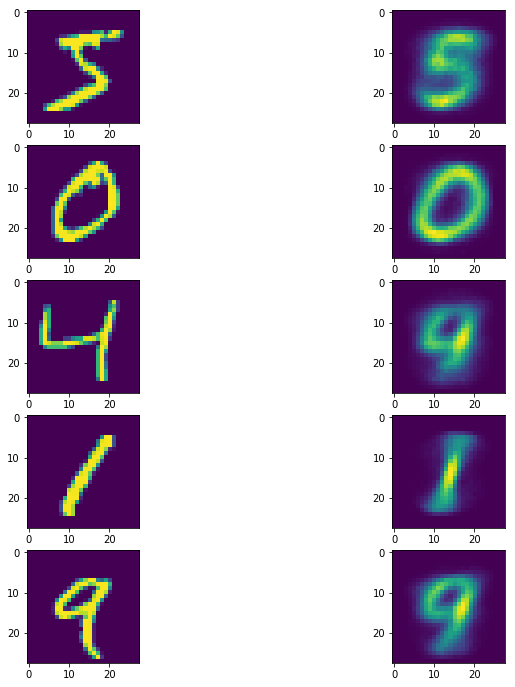

In [26]:
ae.plot_recon(batch=train_images[:5])